# Super Resolution with SRCNN

In [ ]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import math
import cv2
import matplotlib as mpl
import skimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### PSNR (Peak Signal-to-Noise Ratio)
Peak signal-to-noise ratio (PSNR) is a ratio between the maximum possible power of a signal and the power of corrupting noise that affects its representation. It is expressed as a logarithmic quantity using decibel scale.


psnr.svg

In [ ]:
def psnr(y_true, y_pred):
  psnr1 = tf.image.psnr(y_true, y_pred, max_val=255)
  return tf.image.psnr(y_true, y_pred, max_val=255)

**We will convert the original image to a low resolution image and convert it back to the original size using bicubic interpolation available in OpenCV.**

In [ ]:
image = cv2.imread("/content/drive/My Drive/image/train/Abyssinian_100.jpg")
        
# Find old and new image dimensions
h, w, c = image.shape

        
# Resize down the image
image = cv2.resize(image, (int(w/4), int(h/4)), interpolation=cv2.INTER_CUBIC)
        
# Resize up the image
image = cv2.resize(image, (w, h), interpolation=cv2.INTER_CUBIC)
        
# Save the image
try:
    os.listdir('/content/drive/My Drive/image/resized')
except:
    os.mkdir('/content/drive/My Drive/image/resized')
            
cv2.imwrite('/content/drive/My Drive/image/resized/100.jpg', (image))

True

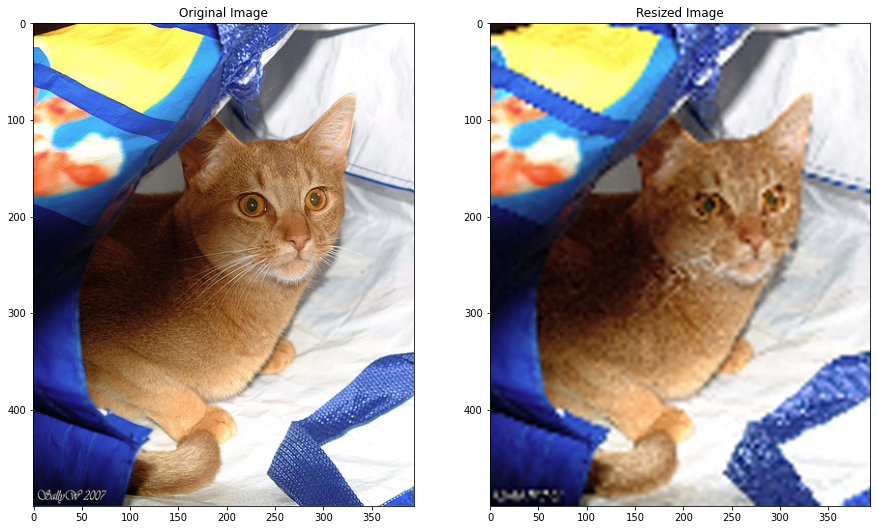

In [ ]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('/content/drive/My Drive/image/train/Abyssinian_100.jpg'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('/content/drive/My Drive/image/resized/100.jpg'))
ax[1].title.set_text('Resized Image')
plt.show()

In [ ]:
y_true = cv2.imread('/content/drive/My Drive/image/train/Abyssinian_100.jpg')
y_pred = cv2.imread('/content/drive/My Drive/image/resized/100.jpg')
psnr(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=24.416887>

**YCbCr format is color model just like the RGB model, Y represents the luma(luminance) component of the image while Cb and Cr represent the blue difference and the red difference chroma components respectively**

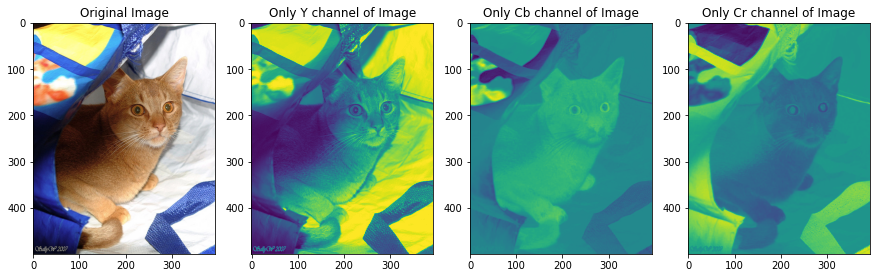

In [ ]:
#for Y channel of image
img = cv2.imread('/content/drive/My Drive/image/train/Abyssinian_100.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
img = img[:,:,0]
cv2.imwrite('/content/drive/My Drive/image/resized/100Y.jpg', (img))

#for Cb channel of image
img = cv2.imread('/content/drive/My Drive/image/train/Abyssinian_100.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
img = img[:,:,1]
cv2.imwrite('/content/drive/My Drive/image/resized/100Cb.jpg', (img))

#for Cb channel of image
img = cv2.imread('/content/drive/My Drive/image/train/Abyssinian_100.jpg',cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
img = img[:,:,2]
cv2.imwrite('/content/drive/My Drive/image/resized/100Cr.jpg', (img))

fig,ax = plt.subplots(1,4,figsize=(15,10))
ax[0].imshow(Image.open('/content/drive/My Drive/image/train/Abyssinian_100.jpg'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('/content/drive/My Drive/image/resized/100Y.jpg'))
ax[1].title.set_text('Only Y channel of Image')
ax[2].imshow(Image.open('/content/drive/My Drive/image/resized/100Cb.jpg'))
ax[2].title.set_text('Only Cb channel of Image')
ax[3].imshow(Image.open('/content/drive/My Drive/image/resized/100Cr.jpg'))
ax[3].title.set_text('Only Cr channel of Image')

**We will be training our model with the Y component of every image**

**Next we will divide every image in the training dataset into cropped patches and store the high resolution and the corresponding low resolution patches in an h5 file with 2 datasets(data-lr, label-hr)**

[ An H5 file is a data file saved in the Hierarchical Data Format (HDF). It contains multidimensional arrays of scientific data.]

In [ ]:
import h5py

names = sorted(os.listdir('/content/drive/My Drive/image/train'))

data = []
label = []

for name in names:
    fpath = '/content/drive/My Drive/image/train/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if (hr_img is not None):
      hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
      hr_img = hr_img[:, :, 0] #Y component of image
      shape = hr_img.shape
    
      # resize operation to produce training data and labels
      lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)), interpolation = cv2.INTER_CUBIC)
      lr_img = cv2.resize(lr_img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
      
      width_range = int((shape[0] - 16 * 2) / 16)
      height_range = int((shape[1] - 16 * 2) / 16)
      
      for k in range(width_range):
          for j in range(height_range):
              x = k * 16
              y = j * 16
              
              hr_patch = hr_img[x: x + 32, y: y + 32]
              lr_patch = lr_img[x: x + 32, y: y + 32]
              
              #Normalization
              hr_patch = hr_patch.astype(np.float32) / 255.
              lr_patch = lr_patch.astype(np.float32) / 255.
              
              hr = np.zeros((1, 20, 20), dtype=np.double)
              lr = np.zeros((1, 32, 32), dtype=np.double)
              
              hr[0, :, :] = hr_patch[6:-6, 6: -6]
              lr[0, :, :] = lr_patch
              
              label.append(hr)
              data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

with h5py.File('train.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)
  
with h5py.File('./train.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))

**Now using random crop (choosing a pixel randomly and storing a patch) we prepare the validation and testing data**

In [ ]:
names = sorted(os.listdir('/content/drive/My Drive/image/val'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = '/content/drive/My Drive/image/val/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if (hr_img is not None):
      hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
      hr_img = hr_img[:, :, 0] #Y component of image
      shape = hr_img.shape
      
      # resize operation to produce training data and labels
      lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)), interpolation = cv2.INTER_CUBIC)
      lr_img = cv2.resize(lr_img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
      
      # Produce random crop
      x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
      y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
      
      for j in range(30):
          lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
          hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]

          #Normalization
          lr_patch = lr_patch.astype(np.float32) / 255.
          hr_patch = hr_patch.astype(np.float32) / 255.
          
          data_test[i * 30 + j, 0, :, :] = lr_patch
          label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

with h5py.File('val.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

with h5py.File('./val.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_val = np.transpose(data, (0, 2, 3, 1))
    y_val = np.transpose(label, (0, 2, 3, 1))

In [ ]:
names = sorted(os.listdir('/content/drive/My Drive/image/test'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = '/content/drive/My Drive/image/test/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if (hr_img is not None):
      hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
      hr_img = hr_img[:, :, 0] #Y component of image
      shape = hr_img.shape
      
      # resize operation to produce training data and labels
      lr_img = cv2.resize(hr_img, (int(shape[1] / 2), int(shape[0] / 2)), interpolation = cv2.INTER_CUBIC)
      lr_img = cv2.resize(lr_img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
      
      # Produce random crop
      x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
      y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
      
      for j in range(30):
          lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
          hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
          
          #Normalization
          lr_patch = lr_patch.astype(np.float32) / 255.
          hr_patch = hr_patch.astype(np.float32) / 255.
          
          data_test[i * 30 + j, 0, :, :] = lr_patch
          label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

with h5py.File('test.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

with h5py.File('./test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((124743, 32, 32, 1),
 (124743, 20, 20, 1),
 (2040, 32, 32, 1),
 (2040, 20, 20, 1),
 (1980, 32, 32, 1),
 (1980, 20, 20, 1))

### **Let us define the SRCNN model using keras in tensorflow**

**Convolutional layer 1 will have 128 filters with a kernel size of 9X9, conv layer 2 will have 64 filters with sizes 1X1 and finally the last conv layer will have 1 filter of size 5X5.**

In [ ]:
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    return SRCNN

In [ ]:
srcnn_model = model()
checkpoint_path = '/content/drive/MyDrive/image/srcnn'
srcnn_model.load_weights(checkpoint_path)
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    8256      
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_path = '/content/drive/My Drive/image/srcnn/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,save_weights_only=True, verbose=1)

**Finally we train our model**

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="/content/drive/My Drive/image/logs",
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    write_steps_per_second=False,
    update_freq=50,
    profile_batch=1500,
    embeddings_freq=0,
    embeddings_metadata=None,
    
)
history1 = srcnn_model.fit(X_train, y_train, batch_size=64, 
                           validation_data=(X_val, y_val), 
                           callbacks = [checkpoint,tensorboard_callback], 
                           shuffle=True, epochs=20, verbose=True)

Epoch 1/20
1949/1950 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.0076
Epoch 00001: val_loss improved from inf to 0.00145, saving model to /content/drive/My Drive/image/srcnn
1950/1950 [==============================] - 542s 278ms/step - loss: 0.0013 - accuracy: 0.0076 - val_loss: 0.0015 - val_accuracy: 0.0137
Epoch 2/20
1949/1950 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.0076
Epoch 00002: val_loss improved from 0.00145 to 0.00143, saving model to /content/drive/My Drive/image/srcnn
1950/1950 [==============================] - 532s 273ms/step - loss: 0.0013 - accuracy: 0.0076 - val_loss: 0.0014 - val_accuracy: 0.0137
Epoch 3/20
1949/1950 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.0076
Epoch 00003: val_loss improved from 0.00143 to 0.00140, saving model to /content/drive/My Drive/image/srcnn
1950/1950 [==============================] - 532s 273ms/step - loss: 0.0012 - accuracy: 0.0076 - val_loss: 0.001

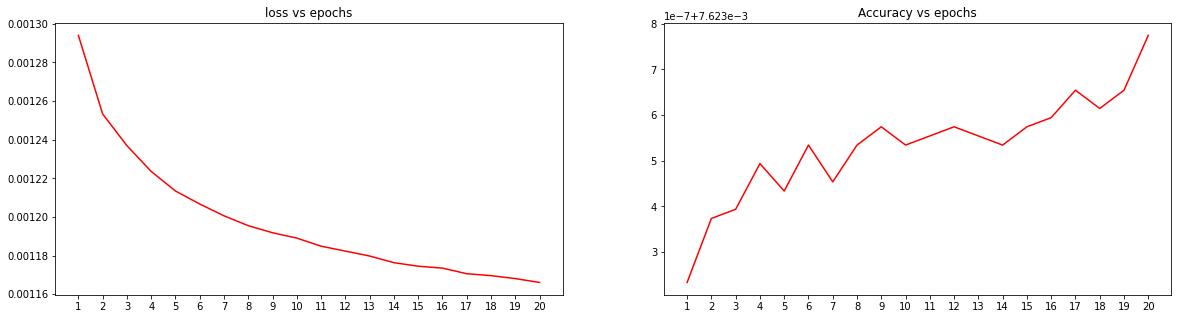

In [ ]:
Loss = history1.history['loss']
Acc = history1.history['accuracy']
X = [x for x in range(1,21)]
fig,ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(X,Loss, color = 'red')
ax[0].set_title('loss vs epochs')
ax[0].set_xticks(X)
ax[1].plot(X,Acc, color = 'red')
ax[1].set_title('Accuracy vs epochs')
ax[1].set_xticks(X)
plt.show()


**Let us make a prediction!!**

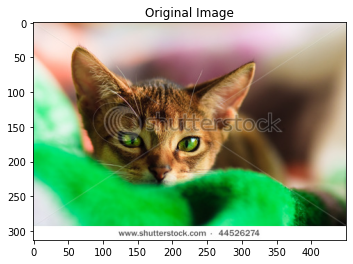

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(Image.open('/content/drive/My Drive/image/train/Abyssinian_101.jpg'))
ax.title.set_text("Original Image")
plt.show()

**Preparing the image for prediction using our model**

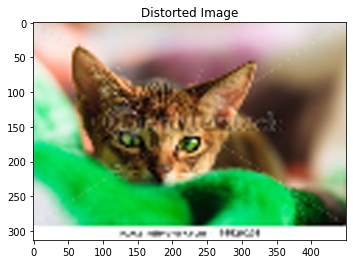

In [ ]:
# Make output directory
try:
    os.listdir('/content/drive/My Drive/image/output')
except:
    os.mkdir('/content/drive/My Drive/image/output')

target = cv2.imread('/content/drive/My Drive/image/train/Abyssinian_101.jpg', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 2
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 4), int(shape[0] / 4)), interpolation = cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('/content/drive/My Drive/image/output/input.jpg', target)

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(Image.open('/content/drive/My Drive/image/output/input.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

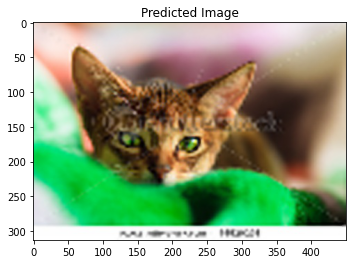

In [ ]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize(min = 0, max = 255)
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('/content/drive/My Drive/image/output/output.jpg', output)

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(Image.open('/content/drive/My Drive/image/output/output.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

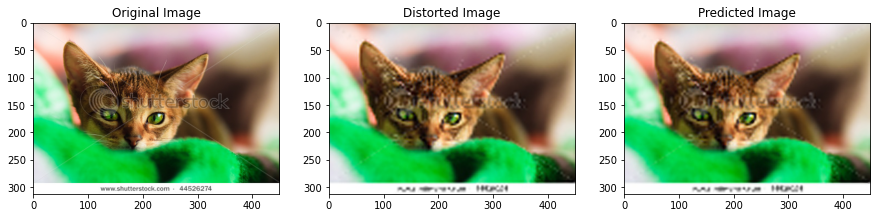

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open('/content/drive/My Drive/image/train/Abyssinian_101.jpg'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open('/content/drive/My Drive/image/output/input.jpg'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open('/content/drive/My Drive/image/output/output.jpg'))
ax[2].title.set_text("Predicted Image")

In [ ]:
original = cv2.imread('/content/drive/My Drive/image/train/Abyssinian_101.jpg')
distorted = cv2.imread('/content/drive/My Drive/image/output/input.jpg')
predicted = cv2.imread('/content/drive/My Drive/image/output/output.jpg')

In [ ]:
print("Original and distorted: PSNR : {}".format(psnr(original, distorted)))
print("Original and predicted: PSNR : {}".format(psnr(original, predicted)))

Original and distorted: PSNR : 25.389873504638672
Original and predicted: PSNR : 25.588180541992188


**As we can see, there is a slight improvement in the super resolution of the distorted image compared to predicted image**